This notebook provides an example to visualize the compression effect brought by utilizing a large weight decay in training.

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.connect import make_tracked_net, reset_bn_stats
from source.utils.logger import Logger
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
class config:
    model = 'cifar_resnet20'
    dataset = 'cifar10'
    special_init = None # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points

In [4]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
model_wd1_1 = load_model(config).to(device)
model_wd5_1 = load_model(config).to(device)

sd_wd1_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/cifar10/{config.model}/diff_init/seed_10/model_1_160.pt')
sd_wd5_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/cifar10/{config.model}/diff_init/seed_10_wd_5/model_1_160.pt')

model_wd1_1.load_state_dict(sd_wd1_1)
model_wd5_1.load_state_dict(sd_wd5_1)

<All keys matched successfully>

In [6]:
model_s = [model_wd1_1, model_wd5_1]
model_tracked_s = [make_tracked_net(model, device, name=config.model) for model in model_s]
for model in model_tracked_s:
    reset_bn_stats(model, device, trainloader_noaug)

In [7]:
import seaborn as sns
plt.style.use("default")

[2024-01-29 15:40:07] (4964) {utils.py:148}INFO - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-01-29 15:40:07] (4964) {utils.py:160}INFO - NumExpr defaulting to 8 threads.


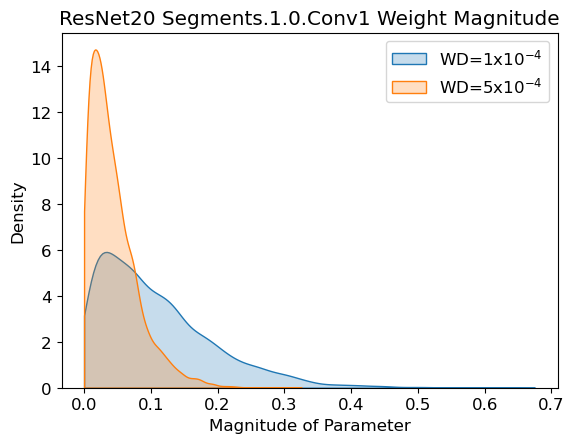

In [8]:
plt.rcParams.update({'font.size': 12})

k = 'segments.1.0.conv1.weight'
sns.kdeplot(sd_wd1_1[k].abs().detach().cpu().flatten(), label=r'WD=1x10$^{-4}$', shade=True, clip=(0, None))
sns.kdeplot(sd_wd5_1[k].abs().detach().cpu().flatten(), label=r'WD=5x10$^{-4}$', shade=True, clip=(0, None))

plt.ylabel('Density')
# plt.yscale('log')
plt.xlabel('Magnitude of Parameter')
plt.title('ResNet20 Segments.1.0.Conv1 Weight Magnitude')
plt.legend()
plt.subplots_adjust(top=0.85)

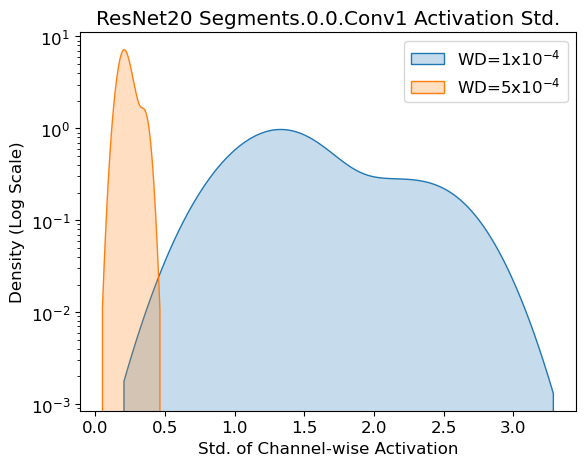

In [9]:
# density plot
plt.rcParams.update({'font.size': 12})

sns.kdeplot(model_tracked_s[0].segments[0][0].conv1.get_stats()[1].detach().cpu(), label=r'WD=1x10$^{-4}$', shade=True, clip=(0, None))
sns.kdeplot(model_tracked_s[-1].segments[0][0].conv1.get_stats()[1].detach().cpu(), label=r'WD=5x10$^{-4}$', shade=True, clip=(0, None))
plt.ylabel('Density (Log Scale)')
plt.yscale('log')
plt.xlabel('Std. of Channel-wise Activation')
# plt.xlim(-0.5)
plt.title('ResNet20 Segments.0.0.Conv1 Activation Std.')
plt.legend()
plt.subplots_adjust(top=0.898)


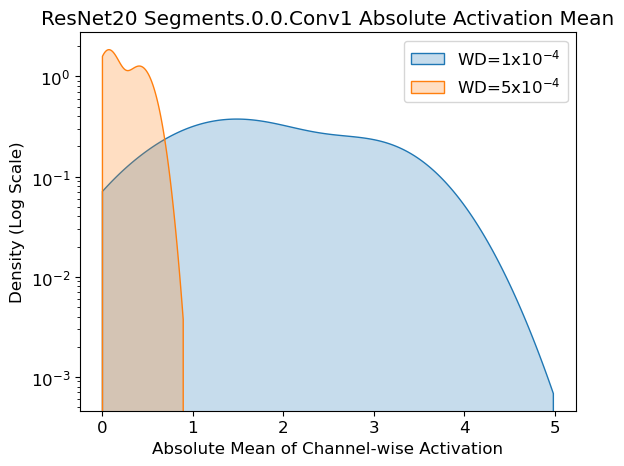

In [10]:
# density plot
plt.rcParams.update({'font.size': 12})
i=10
sns.kdeplot(model_tracked_s[0].segments[0][0].conv1.get_stats()[0].abs().detach().cpu(), label=r'WD=1x10$^{-4}$', fill=True, clip=(0, None))
sns.kdeplot(model_tracked_s[-1].segments[0][0].conv1.get_stats()[0].abs().detach().cpu(), label=r'WD=5x10$^{-4}$', fill=True, clip=(0, None))
plt.ylabel('Density (Log Scale)')
plt.yscale('log')
plt.xlabel('Absolute Mean of Channel-wise Activation')
plt.title('ResNet20 Segments.0.0.Conv1 Absolute Activation Mean')
plt.legend()
plt.subplots_adjust(top=0.898)
# plt.savefig('Figures/wd/resnet20/act_mean.pdf', bbox_inches='tight')